# Run AR6-fair for illustrative path way scenarios from AR6.


These start in 2015 so with @mo-gregmunday we have merged the illustrative pathways from AR6 with RCMIP historical data so the data can start from 1750 and go to 2100. This processing happens in this notebook: ar6_fixer.ipynb

In this notebook we use the AR6 parameter settings to run a constrained ensemble 
    
    * plot the emissions for some of the pathways
    
    * run the 8 pathways through FaIR (this now appears to be working), 
    
    * plot some fields (currently only for the first model) to ensure all is well, 
    
    * output to a csv file.


In [1]:
import fair
import matplotlib.pyplot as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.interpolate import interp1d
from multiprocessing import Pool
from tqdm import tqdm
import json
import pickle
#from climateforcing.twolayermodel import TwoLayerModel
from climateforcing.utils import check_and_download, mkdir_p
import os

In [2]:
# set up plotting
pl.rcParams['figure.figsize'] = (9/2.54, 9/2.54)
pl.rcParams['font.size'] = 12
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['ytick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.major.left'] = True
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['ytick.right'] = True

In [3]:
# Download FaIR params set
check_and_download(
    'https://zenodo.org/record/5513022/files/fair-1.6.2-wg3-params.json', 
    '../data_input/fair_ar6/'
)

In [4]:
with open('../data_input/fair_ar6/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [5]:
len(config_list)

2237

In [6]:
for k in config_list[0].keys():
    print (k)
    

F2x
r0
rt
rc
lambda_global
ocean_heat_capacity
ocean_heat_exchange
deep_ocean_efficacy
b_aero
ghan_params
scale
C_pi
E_pi
ghg_forcing
aCO2land
stwv_from_ch4
F_ref_BC
E_ref_BC
F_solar
F_volcanic
tropO3_forcing
b_tro3
ozone_feedback
natural


In [7]:
rt_list = []
for c in config_list:
    rt_list.append(c['natural'])
print(len(rt_list[0]))

361


In [8]:
rt_list = []
for c in config_list:
    rt_list.append(c["natural"])
print(rt_list[0][0])
print(rt_list[0][1])
print(rt_list[1][0])
print(rt_list[1][1])
len(rt_list[:])

[192.9865502785643, 11.137730226696137]
[194.26764846814376, 11.281236291135704]
[192.9865502785643, 11.137730226696137]
[194.26764846814376, 11.281236291135704]


2237

In [9]:
#scenarios = ['constant_forcing', 'constant_emissions', 'zero', 'scenario', 'infrastructure']
#scenarios = ['constant_emissions', 'zero', 'infrastructure', 'scenario']
# zero and constant emissions will be the easy ones, so start with these.

scenarios = ['CO_Bridge', 
             'DeepElec_SSP2_ HighRE_Budg900', 
             'EN_INDCi2030_500f', 
             'EN_NPi2020_400f_lowBECCS', 
             'EN_NPi2020_900f',
             'SSP2_openres_lc_50',
             'SusDev_SDP-PkBudg1000',
             'LowEnergyDemand_1.3_IPCC' 
            ]

len(scenarios)

8

In [10]:
# Download RCMIP emissions
#check_and_download(
#    'https://zenodo.org/record/4589756/files/rcmip-emissions-annual-means-v5-1-0.csv', 
#    '../data_input/rcmip/'
#)

In [11]:
# Download illustrative pathways
#AR6Pathways = pd.read_csv(
#    '/home/h02/hadcam/github/IllusPathwaysAR6_data/AR6Illus_RCMIP.csv')
    #20210928_ar6emissions_harmonized_infilled_c1_c3_IPs_plus_c2.csv')


#RCMIPhist_data = pd.read_csv('/home/h02/hadcam/github/IllusPathwaysAR6/plushistRCMIP.csv')

#plushist = pd.read_csv('/home/h02/hadcam/github/IllusPathwaysAR6/plushistRCMIP.csv')
#plushist_long = pd.melt(plushist, id_vars=['Model', 'Scenario', 'Region', 'Variable', 'Unit', 'Mip_Era', 'Activity_Id'], var_name='Year')
#rcmip_ar6 = pd.read_csv('/home/h02/hadcam/github/IllusPathwaysAR6/IllusPathsAR6_plushistRCMIP.csv')
#rcmip_ar6_long = pd.melt(rcmip_ar6, id_vars=['Model', 'Scenario', 'Region', 'Variable', 'Unit'], var_name='Year')
#plushist_long.drop(columns=['Mip_Era', 'Activity_Id'], inplace=True)
#rcmip_alldata = pd.concat([plushist_long, rcmip_ar6_long])

#sns.relplot(data=rcmip_alldata, x='Year', y='value', hue='Model')
#g = sns.relplot(data=rcmip_alldata, x='Year', y='value', hue='Model')

#rcmip_alldata.to_csv('/home/h02/hadcam/github/IllusPathwaysAR6/AR6Ilusplus_RCMIPhist.csv')

In [12]:
#new = pd.DataFrame.stack(rcmip_alldata)
#new.to_csv('/home/h02/hadcam/github/IllusPathwaysAR6/AR6Ilusplus_RCMIPhist_wide.csv')

#rcmip_data_wide.to_csv('/home/h02/hadcam/github/IllusPathwaysAR6/AR6Ilusplus_RCMIPhist.csv')

In [13]:
# Download illustrative pathways
#illuspd = pd.read_csv(
#    '/home/h02/hadcam/github/IllusPathwaysAR6/20210928_ar6emissions_harmonized_infilled_c1_c3_IPs_plus_c2.csv')

ssp_df= pd.read_csv('/home/h02/hadcam/github/IllusPathwaysAR6_data/AR6Illus_RCMIP.csv')

fill_years = [str(x) for x in range(2100, 2111)]
for yr in fill_years:
    ssp_df.loc[:, yr] = ssp_df[yr].fillna(ssp_df['2100'])

years = np.arange(1750, 2111)
startyear = 1750
first_scenyear = 2015
last_scenyear = 2111
first_row = int(first_scenyear-startyear)
print(first_row)
last_row = int(last_scenyear-startyear)
print(last_row)

species = [  # in fair 1.6, order is important
    '|CO2|Energy and Industrial Processes', #'MAGICC Fossil and Industrial',
    '|CO2|AFOLU', #'MAGICC AFOLU'
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|PFC|CF4',
    '|PFC|C2F6',
    '|PFC|C6F14',
    '|HFC|HFC23',
    '|HFC|HFC32',
    '|HFC|HFC43-10', # 'HFC4310mee'
    '|HFC|HFC125',
    '|HFC|HFC134a',
    '|HFC|HFC143a',
    '|HFC|HFC227ea',
    '|HFC|HFC245ca', #'HFC245fa'
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

data_out = {}
# 'ssp119','ssp126','ssp245','ssp370',ssp434','ssp585''

for scenario in scenarios:
    print(scenario)
    data_out[scenario] = np.ones((361, 40)) * np.nan
    data_out[scenario][:,0] = years
 
    for i, specie in enumerate(species):
        #print(data_out[scenario].shape,ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014'].shape)
        data_out[scenario][:first_row,i+1] = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f =  ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),'2015':'2111'].dropna(axis=1)*unit_convert[i+1]
        data_out[scenario][first_row:(last_row+1), i+1] = f
        

265
361
CO_Bridge
DeepElec_SSP2_ HighRE_Budg900
EN_INDCi2030_500f
EN_NPi2020_400f_lowBECCS
EN_NPi2020_900f
SSP2_openres_lc_50
SusDev_SDP-PkBudg1000
LowEnergyDemand_1.3_IPCC


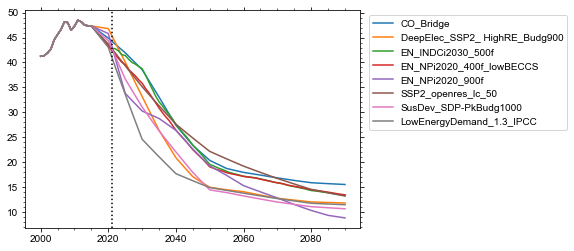

In [14]:
for scenario in scenarios:
    pl.plot(np.arange(2000, 2091), data_out[scenario][250:341,8], label=scenario)    
pl.axvline(2021, ls=':', color='k')
pl.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# Try the first illustrative pathway before looping through the rest of them.

In [15]:
results_out = {}

In [16]:
updated_config = []
for i, cfg in enumerate(config_list):
    updated_config.append({})
    for key, value in cfg.items():
        if isinstance(value, list):
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value
    updated_config[i]['emissions'] = data_out['CO_Bridge']
    updated_config[i]['diagnostics'] = 'AR6'
    updated_config[i]["efficacy"] = np.ones(45)
    updated_config[i]["gir_carbon_cycle"] = True
    updated_config[i]["temperature_function"] = "Geoffroy"
    updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
    updated_config[i]["fixPre1850RCP"] = False
    updated_config[i]["scale"][43] = 0.6
    updated_config[i]["F_solar"] = 0.
    updated_config[i]["F_volcanic"] = 0.
    

In [17]:
print (updated_config[i]['emissions'].shape)
print (updated_config[i]['emissions'])

(361, 40)
[[ 1.75000000e+03  2.59244179e-03  8.11267109e-02 ...  0.00000000e+00
   1.05087730e+02  4.27574490e+03]
 [ 1.75100000e+03  2.59253543e-03  8.26192087e-02 ...  0.00000000e+00
   1.05107200e+02  4.27676850e+03]
 [ 1.75200000e+03  2.59363692e-03  8.41391642e-02 ...  0.00000000e+00
   1.05125020e+02  4.27770490e+03]
 ...
 [ 2.10800000e+03 -3.65469333e-01 -1.09974641e+00 ...  8.10000000e-03
   1.05256100e+02  4.37179310e+03]
 [ 2.10900000e+03 -3.65469333e-01 -1.09974641e+00 ...  8.10000000e-03
   1.05256100e+02  4.37179310e+03]
 [ 2.11000000e+03 -3.65469333e-01 -1.09974641e+00 ...  8.10000000e-03
   1.05256100e+02  4.37179310e+03]]


In [18]:
print (updated_config[i]['natural'].shape)
print (len(updated_config[i]['natural']))

(361, 2)
361


In [19]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:11<00:00, 31.50it/s]


In [20]:
len(result[0])

5

In [21]:
len(updated_config)

2237

In [22]:
result_t = np.array(result).transpose(1,2,0)

In [23]:
results_out['CO_Bridge'] = {}
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['CO_Bridge']['co2_conc'] = c
results_out['CO_Bridge']['temp'] = temp_rebase
results_out['CO_Bridge']['F_ant'] = f_ant
results_out['CO_Bridge']['F_aer'] = f_aer
results_out['CO_Bridge']['F_tot'] = f_tot

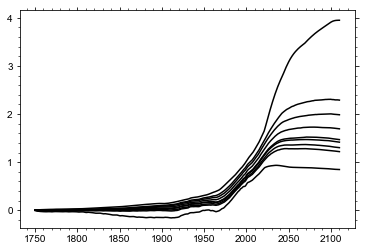

In [24]:
#temp_df = pd.read_csv('../data_input/observations/temp.csv', index_col=0)
#temp_df

for perc in [0,5,10,20,25,50,75,90,100]:
    pl.plot(np.arange(1750,2111),np.percentile(t,perc, axis=1), color='k')


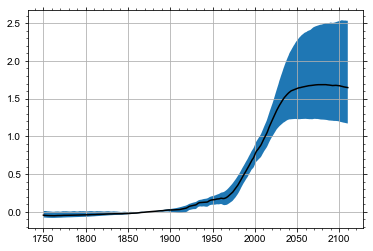

In [25]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['CO_Bridge']['temp'], 5, axis=1), np.percentile(results_out['CO_Bridge']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['CO_Bridge']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

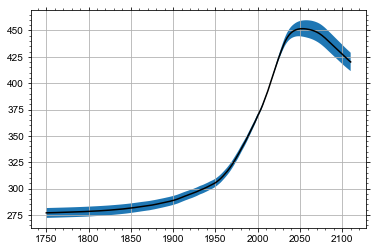

In [26]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['CO_Bridge']['co2_conc'], 5, axis=1), np.percentile(results_out['CO_Bridge']['co2_conc'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['CO_Bridge']['co2_conc'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

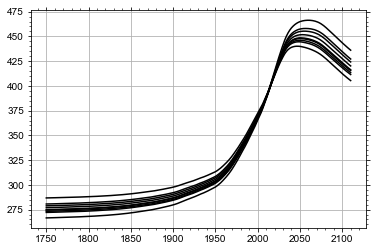

In [27]:
for perc in [0,5,10,20,25,50,75,90,100]:
    pl.plot(np.arange(1750,2111),np.percentile(c,perc, axis=1), color='k')
pl.grid()

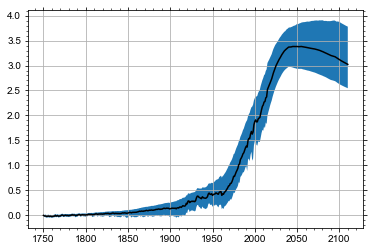

In [28]:
pl.fill_between(np.arange(1750,2111), np.percentile(f_ant, 5, axis=1), np.percentile(f_ant, 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(f_ant, 50, axis=1), color='k')
pl.grid()

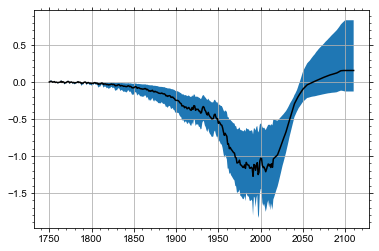

In [29]:
pl.fill_between(np.arange(1750,2111), np.percentile(f_aer, 5, axis=1), np.percentile(f_aer, 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(f_aer, 50, axis=1), color='k')
pl.grid()

In [30]:
np.median(results_out['CO_Bridge']['temp'], axis=1)[245:265].mean()

0.840890490938194

In [31]:
# aerosol forcing is a little less negative than in WG3 because we use CEDS-updated not SSP historical
print(
    np.percentile(results_out['CO_Bridge']['F_aer'], 5, axis=1)[255:265].mean(),
    np.percentile(results_out['CO_Bridge']['F_aer'], 50, axis=1)[255:265].mean(),
    np.percentile(results_out['CO_Bridge']['F_aer'], 95, axis=1)[255:265].mean()
)

-1.682424405295849 -1.1481288263143208 -0.5985614310182676


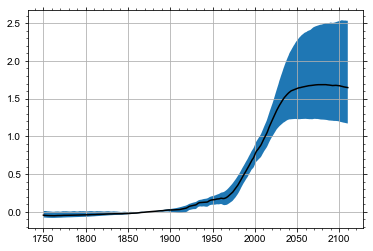

In [32]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['CO_Bridge']['temp'], 5, axis=1), np.percentile(results_out['CO_Bridge']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['CO_Bridge']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

# Loop through the other illustrative pathways

CO_Bridge


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:08<00:00, 32.54it/s]


DeepElec_SSP2_ HighRE_Budg900


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:06<00:00, 33.54it/s]


EN_INDCi2030_500f


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:04<00:00, 34.46it/s]


EN_NPi2020_400f_lowBECCS


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:05<00:00, 34.31it/s]


EN_NPi2020_900f


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:05<00:00, 34.20it/s]


SSP2_openres_lc_50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:05<00:00, 34.37it/s]


SusDev_SDP-PkBudg1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:05<00:00, 33.96it/s]


LowEnergyDemand_1.3_IPCC


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:04<00:00, 34.80it/s]


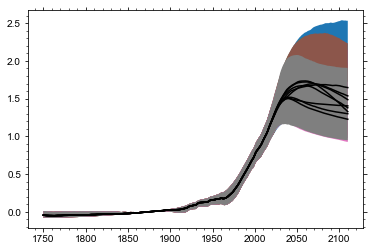

In [33]:
results_out = {}
for scenario in scenarios:
    print (scenario)
    results_out[scenario]={}
    
    updated_config = []
    for i, cfg in enumerate(config_list):
        updated_config.append({})
        for key, value in cfg.items():
            if isinstance(value, list):
                updated_config[i][key] = np.asarray(value)
            else:
                updated_config[i][key] = value
        updated_config[i]['emissions'] = data_out[scenario]
        updated_config[i]['diagnostics'] = 'AR6'
        updated_config[i]["efficacy"] = np.ones(45)
        updated_config[i]["gir_carbon_cycle"] = True
        updated_config[i]["temperature_function"] = "Geoffroy"
        updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
        updated_config[i]["fixPre1850RCP"] = False
        updated_config[i]["scale"][43] = 0.6
        updated_config[i]["F_solar"] = 0.
        updated_config[i]["F_volcanic"] = 0.
    
    def run_fair(args):
        thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
        return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

    if __name__ == '__main__':
        with Pool(28) as pool:
            result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))
    
    results_out[scenario] = {}
    result_t = np.array(result).transpose(1,2,0)
    c, t, f_ant, f_aer, f_tot = result_t
    temp_rebase = t - t[100:151,:].mean(axis=0)
    results_out[scenario]['co2_conc'] = c
    results_out[scenario]['temp'] = temp_rebase
    results_out[scenario]['F_ant'] = f_ant
    results_out[scenario]['F_aer'] = f_aer
    results_out[scenario]['F_tot'] = f_tot

    pl.fill_between(np.arange(1750,2111), np.percentile(results_out[scenario]['temp'], 5, axis=1), np.percentile(results_out[scenario]['temp'], 95, axis=1))
    pl.plot(np.arange(1750,2111), np.percentile(results_out[scenario]['temp'], 50, axis=1), color='k')
    pl.grid()
    

CO_Bridge


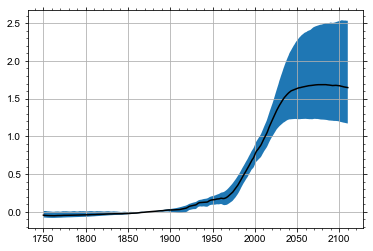

DeepElec_SSP2_ HighRE_Budg900


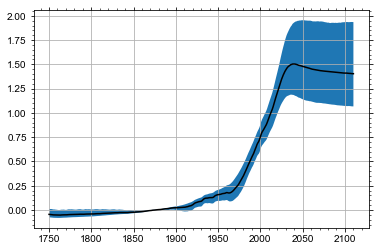

EN_INDCi2030_500f


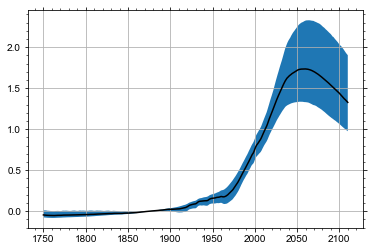

EN_NPi2020_400f_lowBECCS


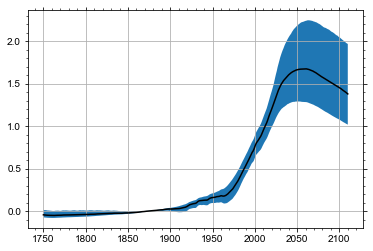

EN_NPi2020_900f


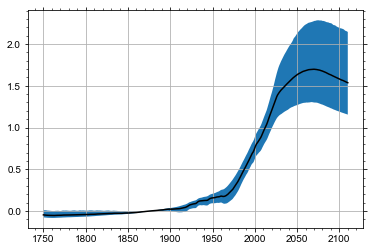

SSP2_openres_lc_50


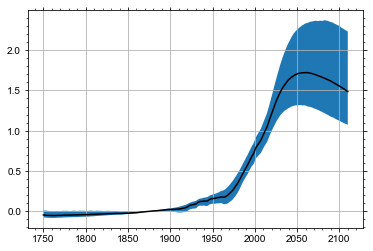

SusDev_SDP-PkBudg1000


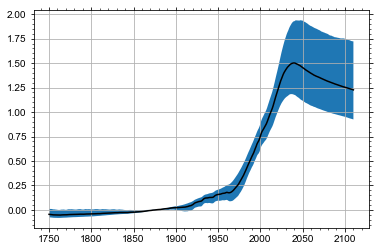

LowEnergyDemand_1.3_IPCC


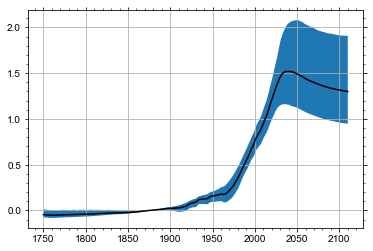

In [34]:
for scenario in scenarios:
    print (scenario)
    pl.fill_between(np.arange(1750,2111), np.percentile(results_out[scenario]['temp'], 5, axis=1), 
                    np.percentile(results_out[scenario]['temp'], 95, axis=1))
    pl.plot(np.arange(1750,2111), np.percentile(results_out[scenario]['temp'], 50, axis=1), color='k')
    #pl.plot(temp_df.index, temp_df.temp, color='r')
    pl.grid()
    pl.pause(5)
   

# All on the same plot!

In [35]:
colors = {'EN_INDCi2030_500f': 'purple', 
        'DeepElec_SSP2_ HighRE_Budg900': 'blue',  
        'SusDev_SDP-PkBudg1000':'pink',
        'LowEnergyDemand_1.3_IPCC':'cyan' ,
        'EN_NPi2020_400f_lowBECCS': 'cyan', 
        'EN_NPi2020_900f': 'orange',      
        'SSP2_openres_lc_50': 'red',      
        'CO_Bridge': 'green', 
         }
labels = {'EN_INDCi2030_500f':'EN_INDCi2030_500f', 
          'DeepElec_SSP2_ HighRE_Budg900':'C1: IMP-Ren', 
          'SusDev_SDP-PkBudg1000':'C1: IMP-SP',
          'LowEnergyDemand_1.3_IPCC':'C1: IMP-LD',
          'EN_NPi2020_400f_lowBECCS':'C2: IMP-Neg', 
          'EN_NPi2020_900f':'C3: Neg-2.0',
          'SSP2_openres_lc_50':'C3: IMP-Ren-2.0',
          'CO_Bridge':'C3: IMP-GS',
           }

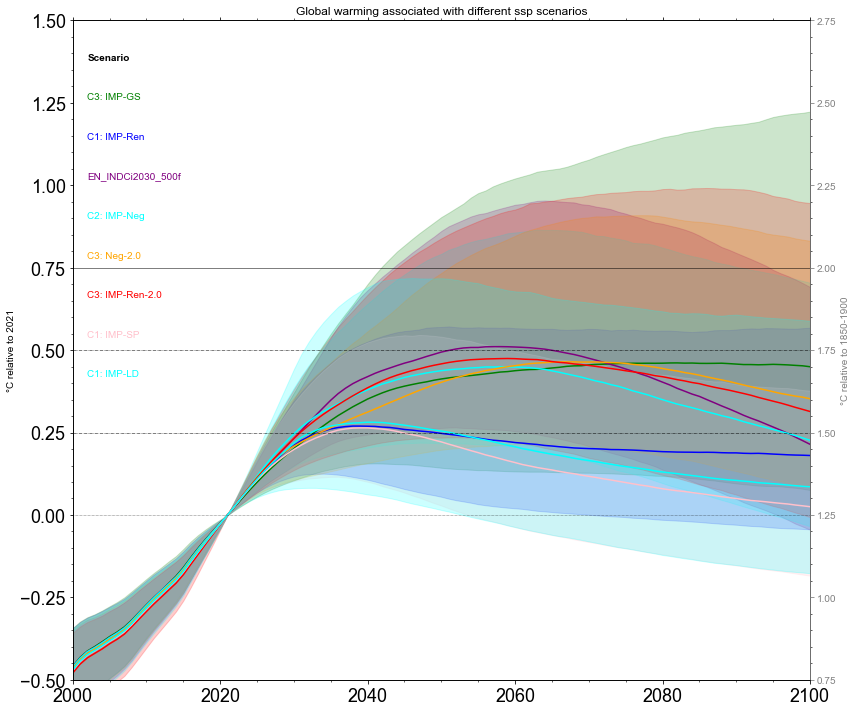

In [36]:
fig, ax = pl.subplots(figsize=(12, 10))

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=10, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], 5, axis=1), np.percentile(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=10)
#ax.legend(fontsize=10);
ax.set_ylabel('°C relative to 2021');
ax.set_title('Global warming associated with different ssp scenarios');
ax.set_xlim(2000, 2100)
ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

ax1 = ax.twinx()
positions = np.arange(0.75, 2.76, 0.25)

ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

ax1.set_ylim(0.75,2.75)
ax1.spines['right'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')
ax1.set_ylabel('°C relative to 1850-1900', color='gray')


ax.axhline(0, ls=':', color='k', lw=0.5)
ax1.axhline(1.5, ls='-.', color='k', lw=0.5)
ax1.axhline(1.75, ls='-.', color='k', lw=0.5)
ax1.axhline(2.0, ls='-', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/rcmip_illus_scenarios_temp.png', dpi=500, transparent=False)

# All on the same plot CO2 conc!

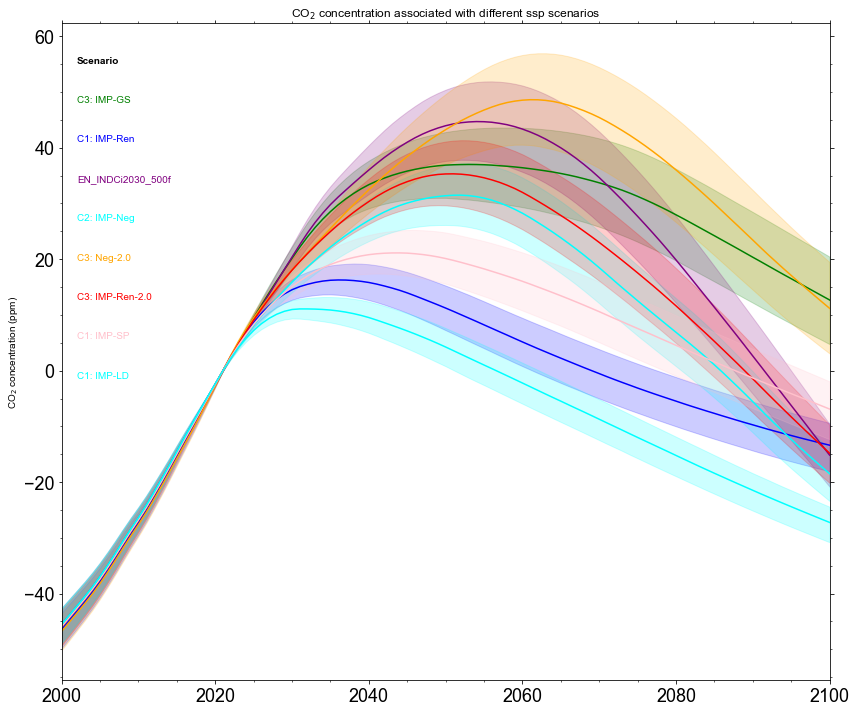

In [37]:
fig, ax = pl.subplots(figsize=(12, 10))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=10, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['co2_conc'][250:351,:] - results_out[scenario]['co2_conc'][271,:], 5, axis=1), np.percentile(results_out[scenario]['co2_conc'][250:351,:] - results_out[scenario]['co2_conc'][271,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['co2_conc'][250:351,:] - results_out[scenario]['co2_conc'][271,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=10)
#ax.legend(fontsize=10);
ax.set_ylabel(r'CO${_2}$ concentration (ppm)');
ax.set_title(r'CO${_2}$ concentration associated with different ssp scenarios');
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker


ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

ax1.spines['right'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')

fig.tight_layout()
pl.savefig('../plots/rcmip_illus_scenarios_CO2conc.png', dpi=500, transparent=False)

# All on the same plot ERF!

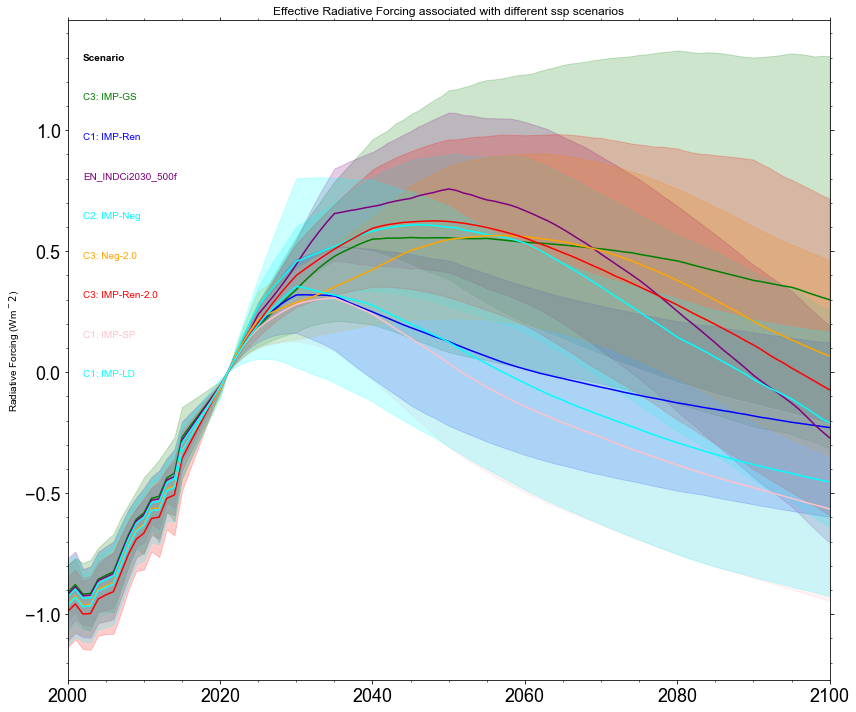

In [38]:
fig, ax = pl.subplots(figsize=(12, 10))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=10, transform=ax.transAxes)
for i, scenario in enumerate(scenarios):
    ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['F_tot'][250:351,:] - results_out[scenario]['F_tot'][271,:], 5, axis=1), np.percentile(results_out[scenario]['F_tot'][250:351,:] - results_out[scenario]['F_tot'][271,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['F_tot'][250:351,:] - results_out[scenario]['F_tot'][271,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=10)
#ax.legend(fontsize=10);
ax.set_ylabel(r'Radiative Forcing (Wm${^-2}$)');
ax.set_title('Effective Radiative Forcing associated with different ssp scenarios');
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker


ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))

ax1.spines['right'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')

fig.tight_layout()
pl.savefig('../plots/rcmip_illus_scenarios_erf.png', dpi=500, transparent=False)

In [41]:
# Output to csv, first create a dataframe 
model_archive = '../csv_FaIRoutputfiles/'
print (scenarios)
print 

if os.path.isdir(model_archive):
    print("Item already exists")
else:
    os.mkdir(model_archive)
    print ("Making the model directory")
    
#model_dir = model_archive+scenario+'/'
    

for scenario in scenarios:
    for variable in results_out[scenario].keys():
        years = 1750+np.arange(len(results_out[scenario][variable]))
        header_text = np.insert(years, 0, 0)
        dic = results_out[scenario][variable]
        
        
        IMPs = {'EN_INDCi2030_500f':'EN_INDCi2030_500f', 
                  'DeepElec_SSP2_ HighRE_Budg900':'C1-IMP-Ren', 
                  'SusDev_SDP-PkBudg1000':'C1-IMP-SP',
                  'LowEnergyDemand_1.3_IPCC':'C1-IMP-LD',
                  'EN_NPi2020_400f_lowBECCS':'C2-IMP-Neg', 
                  'EN_NPi2020_900f':'C3-Neg-2',
                  'SSP2_openres_lc_50':'C3-IMP-Ren-2',
                  'CO_Bridge':'C3-IMP-GS',
           }
        
        
        filename='../csv_FaIRoutputfiles/'+IMPs[scenario]+'_'+variable+'_csv'
        print(filename)
        pd.DataFrame(dic).T.reset_index().to_csv(filename, header=header_text, index=False)

['CO_Bridge', 'DeepElec_SSP2_ HighRE_Budg900', 'EN_INDCi2030_500f', 'EN_NPi2020_400f_lowBECCS', 'EN_NPi2020_900f', 'SSP2_openres_lc_50', 'SusDev_SDP-PkBudg1000', 'LowEnergyDemand_1.3_IPCC']
Item already exists
../csv_FaIRoutputfiles/C3-IMP-GS_co2_conc_csv
../csv_FaIRoutputfiles/C3-IMP-GS_temp_csv
../csv_FaIRoutputfiles/C3-IMP-GS_F_ant_csv
../csv_FaIRoutputfiles/C3-IMP-GS_F_aer_csv
../csv_FaIRoutputfiles/C3-IMP-GS_F_tot_csv
../csv_FaIRoutputfiles/C1-IMP-Ren_co2_conc_csv
../csv_FaIRoutputfiles/C1-IMP-Ren_temp_csv
../csv_FaIRoutputfiles/C1-IMP-Ren_F_ant_csv
../csv_FaIRoutputfiles/C1-IMP-Ren_F_aer_csv
../csv_FaIRoutputfiles/C1-IMP-Ren_F_tot_csv
../csv_FaIRoutputfiles/EN_INDCi2030_500f_co2_conc_csv
../csv_FaIRoutputfiles/EN_INDCi2030_500f_temp_csv
../csv_FaIRoutputfiles/EN_INDCi2030_500f_F_ant_csv
../csv_FaIRoutputfiles/EN_INDCi2030_500f_F_aer_csv
../csv_FaIRoutputfiles/EN_INDCi2030_500f_F_tot_csv
../csv_FaIRoutputfiles/C2-IMP-Neg_co2_conc_csv
../csv_FaIRoutputfiles/C2-IMP-Neg_temp_csv
../c